<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Приветствие-для-ревьюера" data-toc-modified-id="Приветствие-для-ревьюера-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Приветствие для ревьюера</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>LGBM</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
display(df.info())
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Изначально данные у нас поделены на интервал по 10 минут, это не совсем удобно для предсказания на последующий час спроса такси, поэтому сделаем ресемплирование

In [3]:
df = df.resample('1H').sum()
display(df.head(10))
display(len(df))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


4416

Данные на базе, теперь их нужно изучить. Что ж приступим к изучению

## Анализ

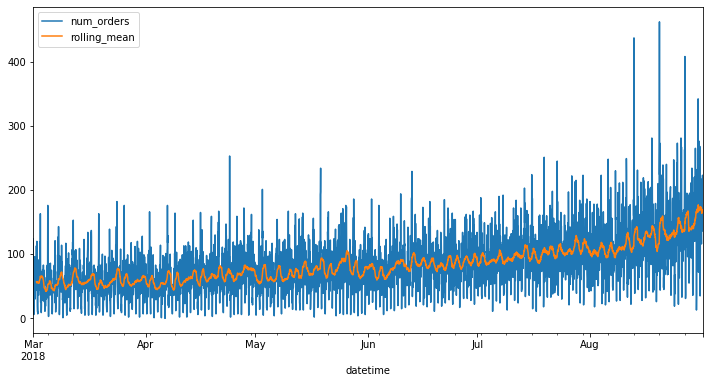

In [4]:
df['rolling_mean'] = df.rolling(24).mean()
df.plot(figsize=(12, 6))

У нас есть исторические данные с марта 2018 по август 2018. В конце мая мы видим скачек заявок, лето это всегда сезон отпусков. Также начиная с первой половины июня кол-во заявок растем самые пиковые значения у нас под конец августа. Это похоже на трен. Посмотрим как выглядит наш тред и сезонность.

In [5]:
df = df.drop(['rolling_mean'], axis=1)

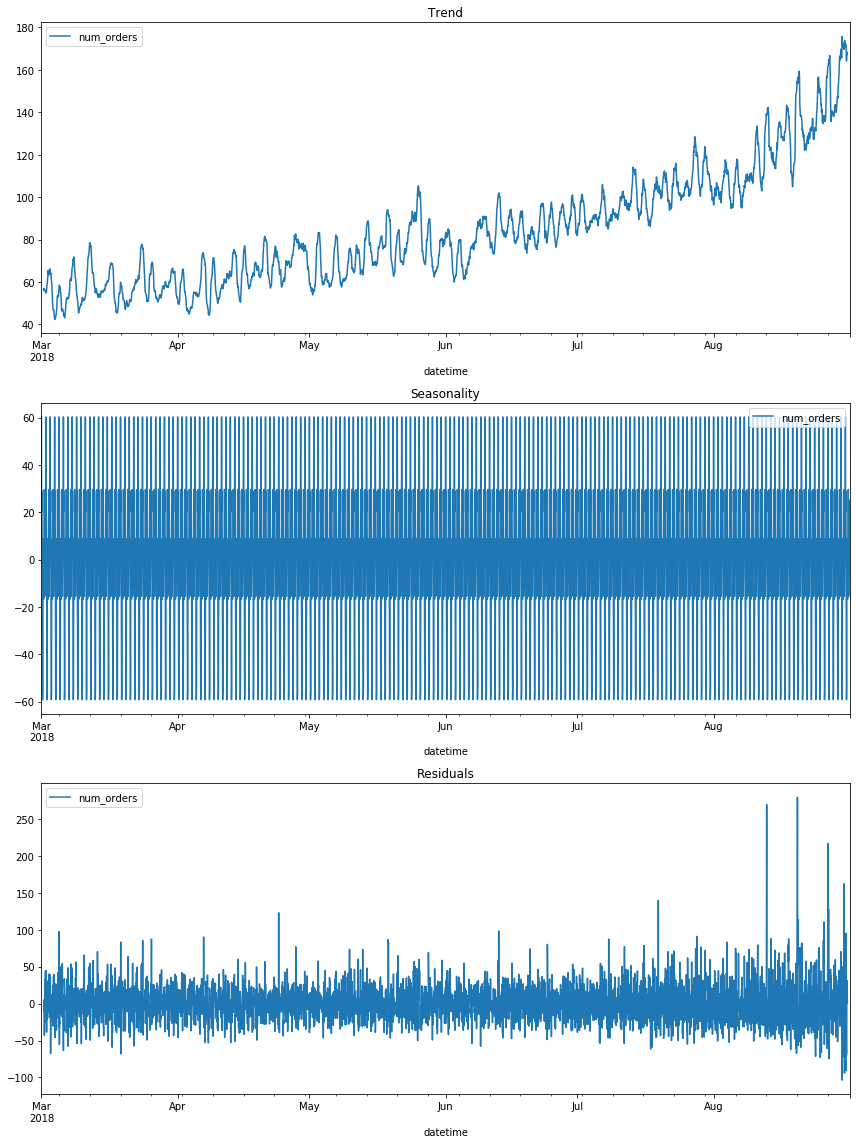

In [6]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд можно объяснить тем, что лето это теплое время года и все стараются взять отпуск именно в это время. Как провести лучше всего отпуск? Конечно же отправиться в путешестие! Именно поэтому и появляется наш тренд. С сезонностью не так все просто, предположим, что она есть в течение дня, поэтому данные график не совсем читабильный. Изучим его отдельно. Остакти иторнпретировать сложно.

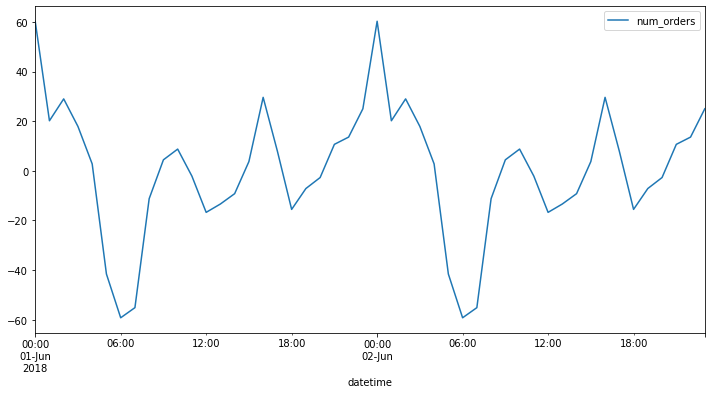

In [7]:
decomposed.sesonal = decomposed.seasonal['2018-06-01':'2018-06-02']
decomposed.sesonal.plot(figsize=(12,6))

Так уже лучше! Наша сезонность зависит от времени! Предположим, что она зависим и от дня недели.

## Обучение

Создадим признаки для нашей модели

Напишем функцию для создания новых признаков. Как мы уже выяснили на сезонность влияют день недели и время дня, поэтому добавим новый признак день недели, сделаем 2 смещения и добавим скользящее среднее с окном 24 и стандартное отклонение с окном 24.

In [8]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df['rolling_std'] = df['num_orders'].shift().rolling(rolling_mean_size).std()

In [9]:
make_features(df, 24, 24)

Разделим данные на тренировочную и тестовыю выборки. Для тестовой выборки оставим 10%

In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [11]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(3950, 27) (442, 27) (3950,) (442,)


Для оценки наших моделей будем использовать метрику RMSE(среднеквадратичное отклонение)

In [12]:
def RMSE(target, predict):
    return mean_squared_error(target,predict)**0.5

In [13]:
score = make_scorer(RMSE, greater_is_better=False)

### LinearRegression

In [16]:
LinearReg_model = LinearRegression()

In [17]:
%%time
LinearReg_model.fit(features_train, target_train)

CPU times: user 16.4 ms, sys: 1.17 ms, total: 17.6 ms
Wall time: 7.69 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
%%time
LinReg_pred = LinearReg_model.predict(features_train)

CPU times: user 1.04 ms, sys: 16 ms, total: 17 ms
Wall time: 5.51 ms


In [19]:
print('RMSE: ', RMSE(target_train, LinReg_pred).round(2))

RMSE:  25.92


### Catboost

In [20]:
Catboost_model = CatBoostRegressor(verbose = 10, random_seed = 29)

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

In [22]:
param_grid = {'iterations': [10, 50], 'max_depth': [5, 15]}

In [23]:
grid_cv = GridSearchCV(Catboost_model, param_grid, scoring=score, cv=tscv)

In [ ]:
%%time
grid_cv.fit(features_train, target_train, verbose=False)

In [ ]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

In [ ]:
Catboost_model = CatBoostRegressor(verbose = 10, iterations = 50, max_depth = 5)

In [ ]:
%%time
Catboost_model.fit(features_train, target_train)

In [ ]:
%%time
Catboost_pred = Catboost_model.predict(features_train)

In [ ]:
print('RMSE: ', RMSE(target_train, Catboost_pred).round(2))

### LGBM

In [ ]:
LGBM_model = LGBMRegressor(random_state = 29, n_job=-1)

In [ ]:
LGBM_model

In [ ]:
param_grid = {'n_estimators': [100, 1000], 'max_depth': [5, 15]}

In [ ]:
grid_cv = GridSearchCV(LGBM_model, param_grid, scoring=score, cv=tscv)

In [ ]:
%%time
grid_cv.fit(features_train, target_train, verbose=True)

In [ ]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

In [ ]:
LGBM_model = LGBMRegressor(random_state = 29, max_depth= 5, n_estimators= 100, n_job=-1)

In [ ]:
%%time
LGBM_model.fit(features_train, target_train)

In [ ]:
%%time
LGBM_pred = LGBM_model.predict(features_train)

In [ ]:
print('RMSE: ', RMSE(target_train, LGBM_pred).round(2))

## Тестирование

### LinearRegression

In [ ]:
%%time
LinReg_pred = LinearReg_model.predict(features_test)

In [ ]:
print('RMSE: ', RMSE(target_test, LinReg_pred).round(2))

### Catboost

In [ ]:
%%time
Catboost_pred = Catboost_model.predict(features_test)

In [ ]:
print('RMSE: ', RMSE(target_test, Catboost_pred).round(2))

### LGBM

In [ ]:
%%time
LGBM_pred = LGBM_model.predict(features_test)

In [ ]:
print('RMSE: ', RMSE(target_test, LGBM_pred).round(2))

## Вывод

In [6]:
result=pd.DataFrame({'Модель':['LinearRegression', 'CatBoost', 'LGBM'],
 'Скорость подбора гиперпараметров':['Гиперпараметров нет', '5 мин 10 сек', '6,65 сек'],
 'Скорость обучения':['6.81 мсек', '217 мсек', '108 сек'],
 'Скорость предсказания': ['83,5 мсек', '3,95 мсек', '21,9 сек'],
 'Качество предсказания(RMSE)': ['45', '44', '43']})
result

,Модель,Скорость подбора гиперпараметров,Скорость обучения,Скорость предсказания,Качество предсказания(RMSE)
0,LinearRegression,Гиперпараметров нет,6.81 мсек,"83,5 мсек",45
1,CatBoost,5 мин 10 сек,217 мсек,"3,95 мсек",44
2,LGBM,"6,65 сек",108 сек,"21,9 сек",43


По результатам исследования мы подобрали модель для предсказания спроса такси на один час. Лучшей моделью мы получили градиентный бустинг LGBM. Но так как мы предлагаем модель для дествующего бизнеса, то наша рекомендация использовать простую модель линейной регресси, она показала хороший результат и в дальнейшем данную модель будет не сложно поддерживать и обновлять.